In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np
import pandas as pd

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
# mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [3]:
# plot correlations for seeing how similar features are
def plot_correlation_map(df):
    corr = df.corr()
    _, ax = plt.subplots(figsize=(12, 10))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    _ = sns.heatmap(
        corr,
        cmap=cmap,
        square=True,
        cbar_kws={'shrink': .9},
        ax=ax,
        annot=True,
        annot_kws={'fontsize': 12}
    )

In [4]:
# First we load in our dataset
df = pd.read_csv('../data/raw/data.txt')
df.head()

,Sequences
0,1 1
1,2
2,3 2 2 4 2 2 2 3 3
3,5
4,1


In [5]:
# get lengths
def get_length(input):
    return len(input.split(' ')) - 1

# get unique pages viewed
def get_unique_length(input):
    return len(set(input.split(' '))) - 1


df['sequence_length'] = df['Sequences'].apply(get_length)
df['unique_sequence_length'] = df['Sequences'].apply(get_unique_length)
df.head(10)

,Sequences,sequence_length,unique_sequence_length
0,1 1,2,1
1,2,1,1
2,3 2 2 4 2 2 2 3 3,9,3
3,5,1,1
4,1,1,1
5,6,1,1
6,1 1,2,1
7,6,1,1
8,6 7 7 7 6 6 8 8 8 8,10,3
9,6 9 4 4 4 10 3 10 5 10 4 4 4,13,6


In [6]:
df.describe()

,sequence_length,unique_sequence_length
count,989818.000000,989818.000000
mean,4.747129,1.716783
std,21.257389,1.191411
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,1.000000
75%,5.000000,2.000000
max,14795.000000,17.000000


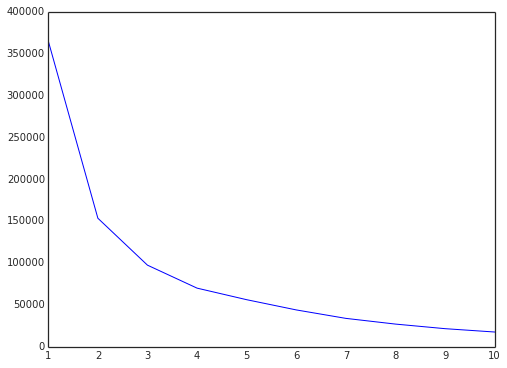

In [7]:
gb_len = df['sequence_length'].value_counts()
gb_len.plot(xlim=(1,10))

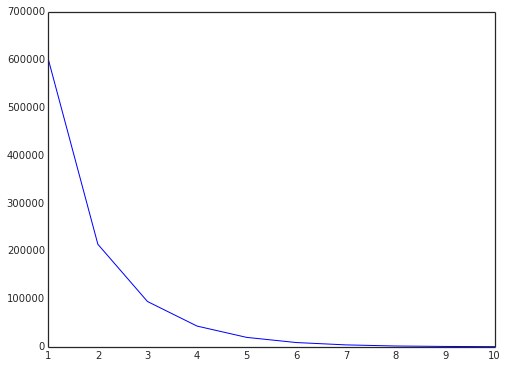

In [8]:
gb_len = df['unique_sequence_length'].value_counts()
gb_len.plot(xlim=(1,10))

In [9]:
df.groupby(["sequence_length", "unique_sequence_length"]).size().head(10)

sequence_length  unique_sequence_length
1                1                         365435
2                1                          98541
                 2                          55073
3                1                          45237
                 2                          42478
                 3                           9825
4                1                          26373
                 2                          29621
                 3                          12211
                 4                           1885
dtype: int64

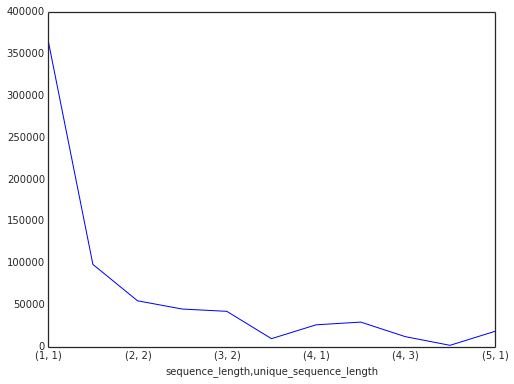

In [10]:
df.groupby(["sequence_length", "unique_sequence_length"]).size().plot(xlim=(0,10))

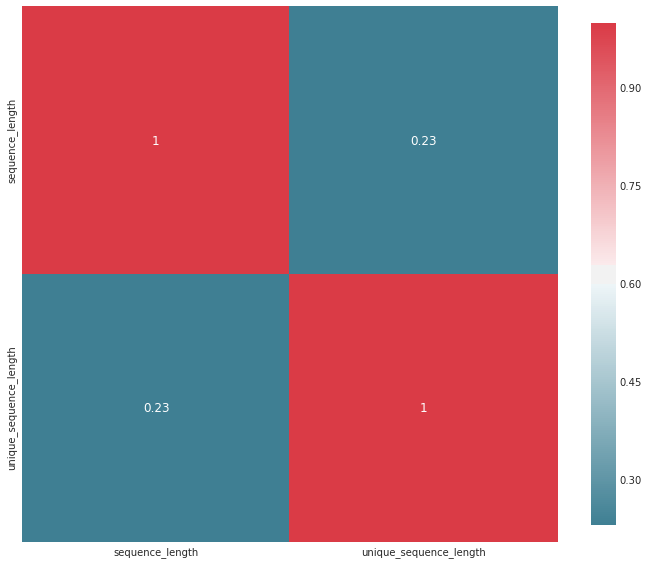

In [11]:
plot_correlation_map(df)

Something that is subtley availible in our dataset is the pages that users enter or exit the site on. While we could simply look at the final cell it makes more sense to append a 0 and 18 onto each string so this can be measured by our algorithms and in a visualisation.

In [13]:
def add_s_e(input):
    return '0 ' + input + ' 18'

# append to sequences
df['sequence_full'] = df['Sequences'].apply(add_s_e)
df.head(10)

,Sequences,sequence_length,unique_sequence_length,sequence_full
0,1 1,2,1,0 1 1 18
1,2,1,1,0 2 18
2,3 2 2 4 2 2 2 3 3,9,3,0 3 2 2 4 2 2 2 3 3 18
3,5,1,1,0 5 18
4,1,1,1,0 1 18
5,6,1,1,0 6 18
6,1 1,2,1,0 1 1 18
7,6,1,1,0 6 18
8,6 7 7 7 6 6 8 8 8 8,10,3,0 6 7 7 7 6 6 8 8 8 8 18
9,6 9 4 4 4 10 3 10 5 10 4 4 4,13,6,0 6 9 4 4 4 10 3 10 5 10 4 4 4 18


My goal here is to build a graph using SankeyMatic, which shows the flows through a site from start to finish, it may look weird as this is cyclic but we will see. I realise this won't really work for cyclic graphs, but could be interesting for visualizing the start and end points so lets look at that. In order to use this I need to know how many people entered and exited from each cell, so I need the first number before an exit and after an enterence.

In [25]:
# get entry point
def get_entry(input):
    return input.split(' ')[1]

# get exit point
def get_exit(input):
    return input.split(' ')[-3]
    
# entry and exits
df['entry'] = df['sequence_full'].apply(get_entry)
df['exit'] = df['sequence_full'].apply(get_exit)
df.head(10)

,Sequences,sequence_length,unique_sequence_length,sequence_full,entry,exit
0,1 1,2,1,0 1 1 18,1,1
1,2,1,1,0 2 18,2,2
2,3 2 2 4 2 2 2 3 3,9,3,0 3 2 2 4 2 2 2 3 3 18,3,3
3,5,1,1,0 5 18,5,5
4,1,1,1,0 1 18,1,1
5,6,1,1,0 6 18,6,6
6,1 1,2,1,0 1 1 18,1,1
7,6,1,1,0 6 18,6,6
8,6 7 7 7 6 6 8 8 8 8,10,3,0 6 7 7 7 6 6 8 8 8 8 18,6,8
9,6 9 4 4 4 10 3 10 5 10 4 4 4,13,6,0 6 9 4 4 4 10 3 10 5 10 4 4 4 18,6,4


In [19]:
get_entry('0 1 2 2 4 2 2 2 3 9 18')

'1'